In [1]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def std_npe(row):
    return np.std(row.to_numpy())

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   


In [2]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [3]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [5]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39_07_08_2020", "Ar39_Snapshots")
fileinprefix = "Snapshot1Ar39*.csv"

df_ar39 = load_dataframe_from_files(dirin, fileinprefix, max_files=100)
df_ar39 = df_ar39[df_ar39.pedetected>0]
df_ar39 = df_ar39[df_ar39.columns[:-1]]

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*.csv
...................................................................................................


In [7]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Muons_07_08_2020", "Muon_Snapshots")
fileinprefix = "SnapshotMuons*.csv"

df_mu = load_dataframe_from_files(dirin, fileinprefix, max_files=100)
df_mu = df_mu[df_mu.pedetected>0]
df_mu = df_mu[df_mu.columns[:-1]]

[Info] Loading 100 files wt prefix:
SnapshotMuons*.csv
...................................................................................................


In [8]:
maxPEar39 = df_ar39.pedetected.max()
df_lemu = df_mu[df_mu.pedetected <= maxPEar39]
print("[Info] Loaded {} Ar39 decays, with maximum {} PE detected".format(len(df_ar39), maxPEar39))
print("[Info] Selected {} Muons, with maximum {} PE detected".format(len(df_lemu), df_lemu.pedetected.max()))

[Info] Loaded 6308949 Ar39 decays, with maximum 60 PE detected
[Info] Selected 4598 Muons, with maximum 60 PE detected


## Are LE-Mu vs 1Ar39 easily detectable wt NrActiveSlices? NO

In [9]:
n_inner_slices, n_outer_slices = 12, 20
df_mu["NActiveSlices_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_mu["NActiveSlices_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39["NActiveSlices_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39["NActiveSlices_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)

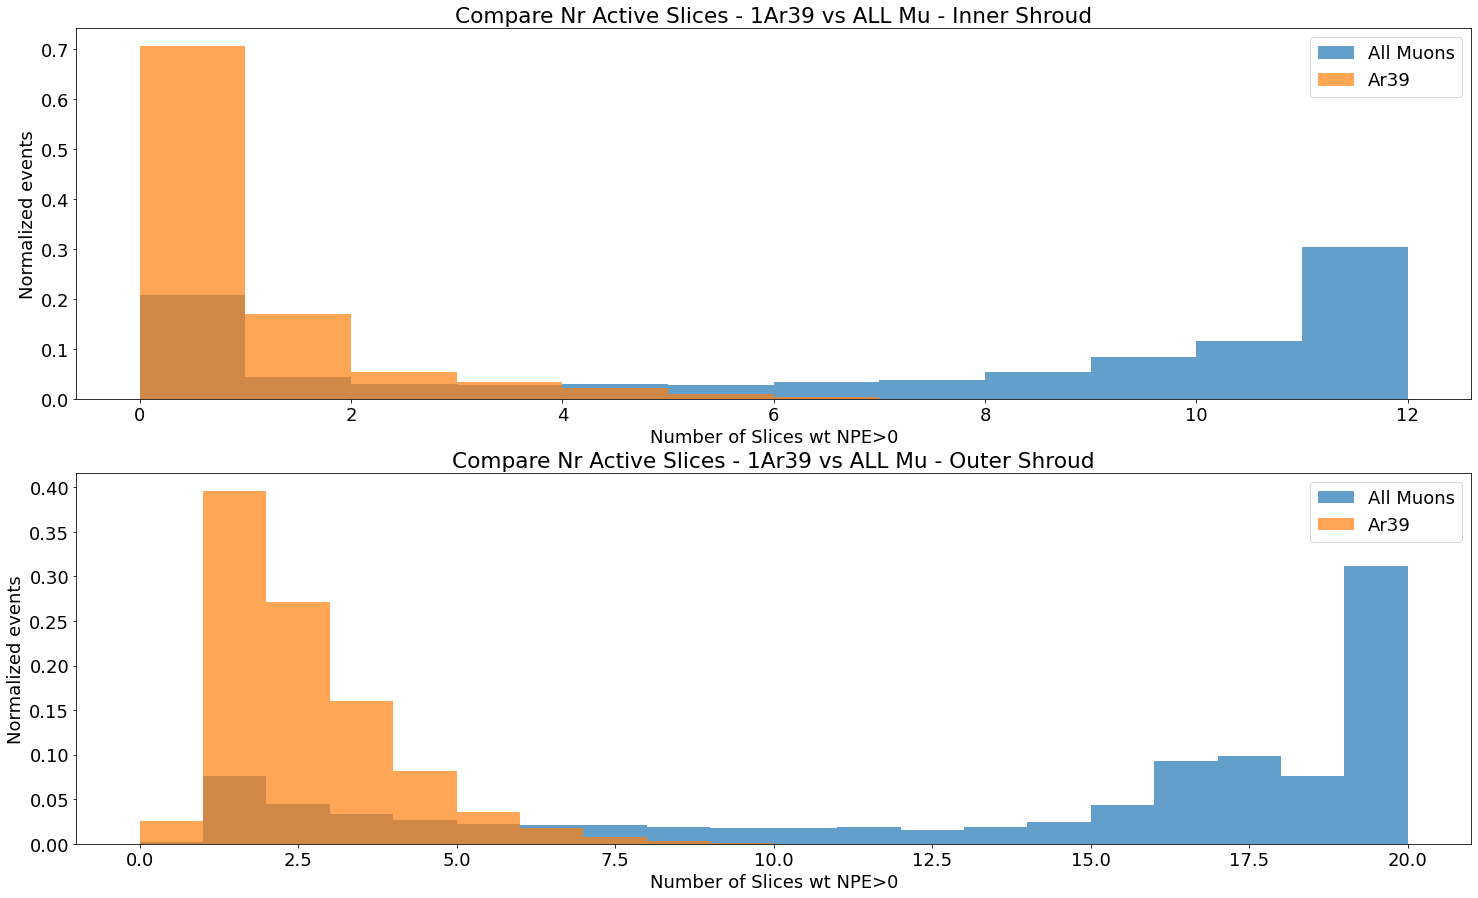

In [10]:
plt.subplot(2, 1, 1)
bins = np.linspace(0, n_inner_slices, n_inner_slices+1)
plt.title("Compare Nr Active Slices - 1Ar39 vs ALL Mu - Inner Shroud")
plt.hist(df_mu.NActiveSlices_inner, bins=bins, label="All Muons", density=True, alpha=0.7)
plt.hist(df_ar39.NActiveSlices_inner, bins=bins, label="Ar39", density=True, alpha=0.7)
plt.xlabel("Number of Slices wt NPE>0")
plt.ylabel("Normalized events")
plt.legend()

plt.subplot(2, 1, 2)
bins = np.linspace(0, n_outer_slices, n_outer_slices+1)
plt.title("Compare Nr Active Slices - 1Ar39 vs ALL Mu - Outer Shroud")
plt.hist(df_mu.NActiveSlices_outer, bins=bins, label="All Muons", density=True, alpha=0.7)
plt.hist(df_ar39.NActiveSlices_outer, bins=bins, label="Ar39", density=True, alpha=0.7)
plt.xlabel("Number of Slices wt NPE>0")
plt.ylabel("Normalized events")
plt.legend()
plt.show()

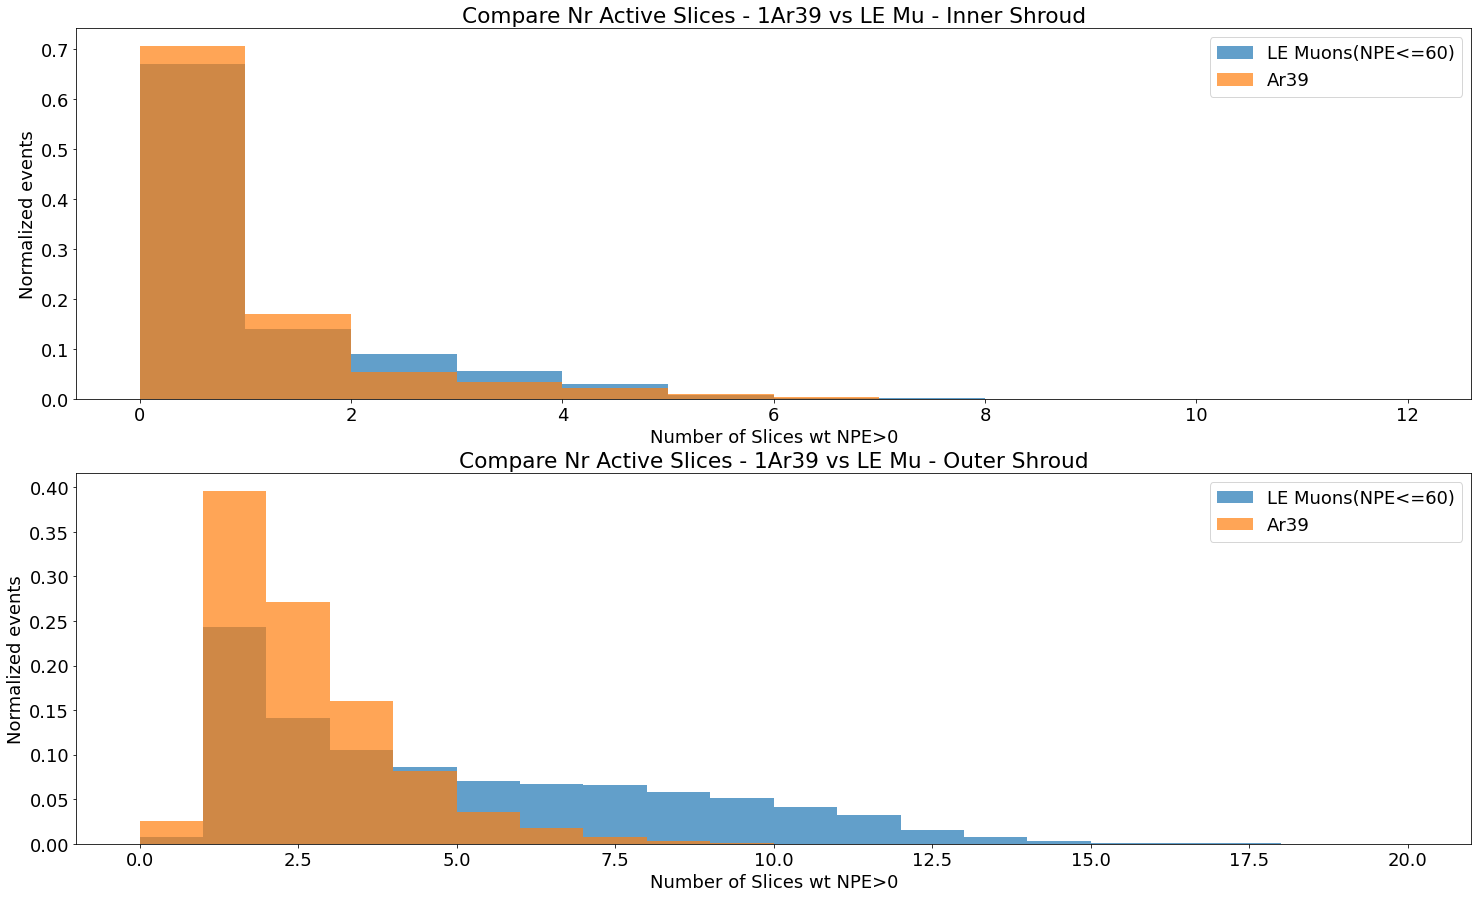

In [11]:
plt.subplot(2, 1, 1)
bins = np.linspace(0, n_inner_slices, n_inner_slices+1)
plt.title("Compare Nr Active Slices - 1Ar39 vs LE Mu - Inner Shroud")
plt.hist(df_mu[df_mu.pedetected<=60].NActiveSlices_inner, bins=bins, label="LE Muons(NPE<=60)", density=True, alpha=0.7)
plt.hist(df_ar39.NActiveSlices_inner, bins=bins, label="Ar39", density=True, alpha=0.7)
plt.xlabel("Number of Slices wt NPE>0")
plt.ylabel("Normalized events")
plt.legend()

plt.subplot(2, 1, 2)
bins = np.linspace(0, n_outer_slices, n_outer_slices+1)
plt.title("Compare Nr Active Slices - 1Ar39 vs LE Mu - Outer Shroud")
plt.hist(df_mu[df_mu.pedetected<=60].NActiveSlices_outer, bins=bins, label="LE Muons(NPE<=60)", density=True, alpha=0.7)
plt.hist(df_ar39.NActiveSlices_outer, bins=bins, label="Ar39", density=True, alpha=0.7)
plt.xlabel("Number of Slices wt NPE>0")
plt.ylabel("Normalized events")
plt.legend()
plt.show()

In [12]:
print("Cut on NActiveSlices_outer>=2:")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices_outer>=2)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices_outer>=2)])/len(df_ar39)))
print()

print("Cut on NActiveSlices_outer>=3:")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices_outer>=3)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices_outer>=3)])/len(df_ar39)))
print()

print("Cut on NActiveSlices_outer>=5")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices_outer>=5)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices_outer>=5)])/len(df_ar39)))
print()

print("Cut on NActiveSlices_outer>=6")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices_outer>=6)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices_outer>=6)])/len(df_ar39)))
print()

print("Cut on NActiveSlices_outer>=7")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices_outer>=7)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices_outer>=7)])/len(df_ar39)))
print()

Cut on NActiveSlices_outer>=2:
Eff: 0.9217615525547941
FPR: 0.5786566035008367

Cut on NActiveSlices_outer>=3:
Eff: 0.8776548822691186
FPR: 0.30722565676153035

Cut on NActiveSlices_outer>=5
Eff: 0.8177376670964239
FPR: 0.06574010980275796

Cut on NActiveSlices_outer>=6
Eff: 0.795616475537762
FPR: 0.029582264811460673

Cut on NActiveSlices_outer>=7
Eff: 0.7747166994639343
FPR: 0.011861246619682613



## Observation on NrActiveSlices:
1. Aiming to have a FPR<3% on 1 Ar39, we should cut on >=6 Active Slices in the outer shroud.
1. This would lead to an efficiency of ~80% on all muons.

In the following, we will focus on LE-Muons to see if we can extract more sophisticated patterns

## Remove Test Data for later evaluation

In [14]:
# Remove test data for later eval
n_train_mu, n_train_ar = 598, 2000000
muons_test, muons_train = df_lemu.iloc[:n_train_mu, :], df_lemu.iloc[n_train_mu:, :]
ar39_test, ar39_train = df_ar39.iloc[:n_train_ar, :], df_ar39.iloc[n_train_ar:, :]
print("[Info] Muon Train {}, Test {}".format(len(muons_train), len(muons_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_train), len(ar39_test)))

[Info] Muon Train 4000, Test 598
[Info] Ar39 Train 4308949, Test 2000000


### Undersample Ar39

In [15]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, 61, 62)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(61)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), 0), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, 61):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

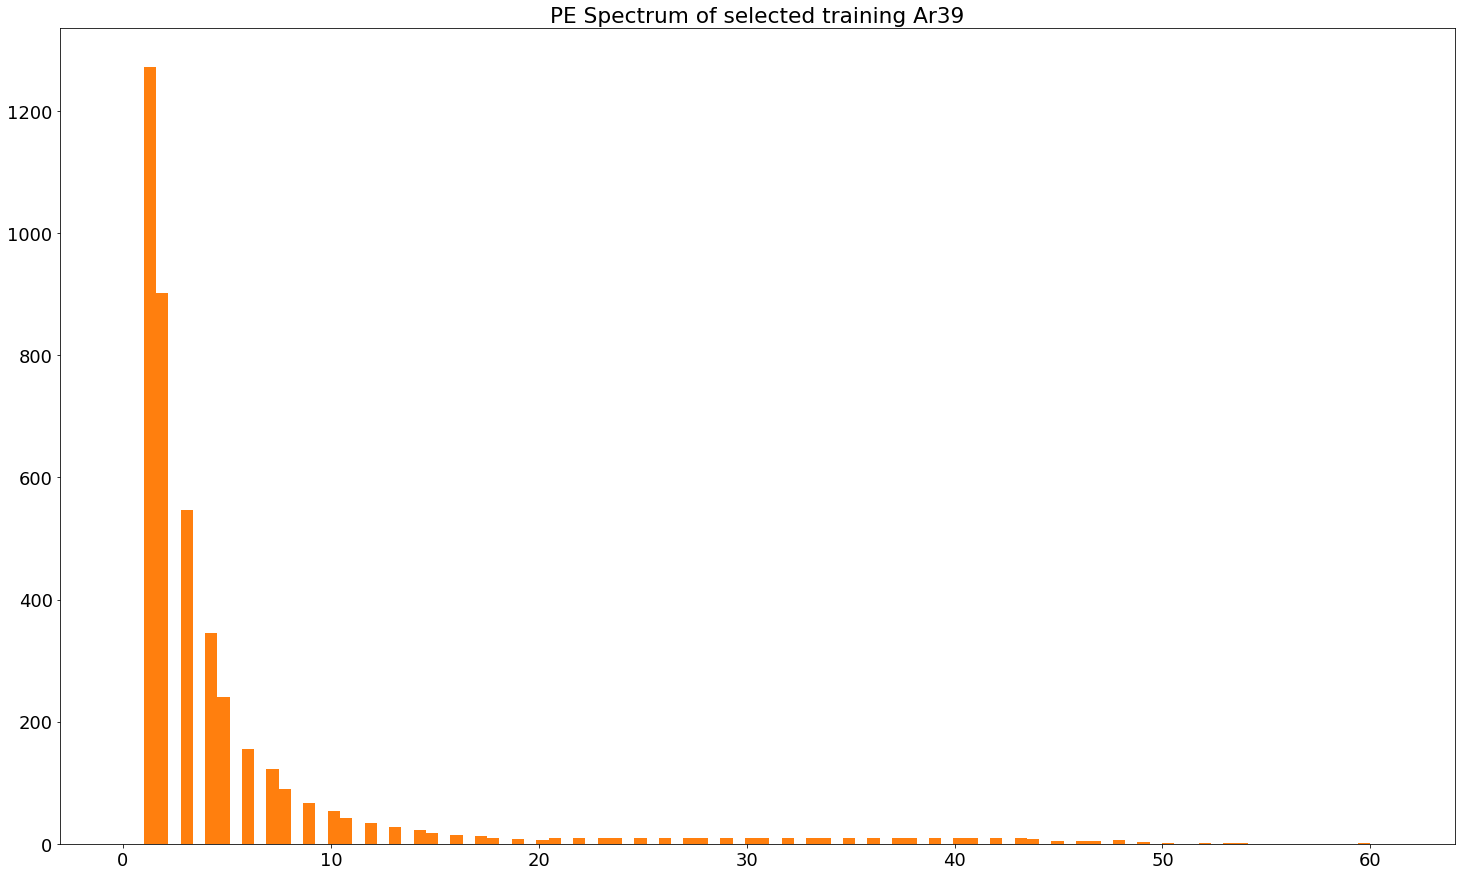

[Info] Undersample Ar39: 4255 instances


In [16]:
sampled_ar39 = undersample_argon(ar39_train, len(muons_train), augment_from_pe=20, augmentation_nr=10, skip_first_cols=3, nslices=n_inner_slices+n_outer_slices)
plt.title("PE Spectrum of selected training Ar39")
plt.hist(sampled_ar39.sum(axis=1), bins=100)
plt.show()

print("[Info] Undersample Ar39: {} instances".format(sampled_ar39.shape[0]))

In [17]:
# Compute features muon
import time

init = time.time()
mu_feat = pd.DataFrame()
mu_feat["PEDetected_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPE_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe(row), axis=1)
mu_feat["StdNPE_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe(row), axis=1)
mu_feat["SpatialRange_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_feat["PEDetected_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPE_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
mu_feat["StdNPE_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
mu_feat["SpatialRange_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar39_feat = pd.DataFrame()
ar39_feat["PEDetected_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["MeanNPE_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe(row), axis=1)
ar39_feat["StdNPE_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe(row), axis=1)
ar39_feat["SpatialRange_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialVar_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
ar39_feat["SpatialStd_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar39_feat["PEDetected_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["MeanNPE_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
ar39_feat["StdNPE_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
ar39_feat["SpatialRange_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialVar_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
ar39_feat["SpatialStd_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))


Compute Mu Inner features: 0.570 sec
Compute Mu Outer features: 0.823 sec
Compute Ar39 Inner features: 0.657 sec
Compute Ar39 Outer features: 0.785 sec


# Feature Selection

## Importance ~ F-score

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Prepare data for training
mu_feat["y"] = 1
ar39_feat["y"] = 0
data = pd.concat([mu_feat, ar39_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Feature selection based on relation wt output variable
print("Feature Importance - Relation wt Output Label")
bestfeatures = SelectKBest(score_func=f_classif, k=len(X.columns))
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X.columns),'Score'))  #print 10 best features

Feature Importance - Relation wt Output Label
                  Specs        Score
8   NActiveSlices_outer  1725.229200
11   SpatialRange_outer  1651.835916
7      PEDetected_outer  1219.364976
13     SpatialStd_outer  1141.708802
10         StdNPE_outer   999.291828
9         MeanNPE_outer   990.790047
12     SpatialVar_outer   743.716076
3          StdNPE_inner   165.020250
2         MeanNPE_inner   114.036223
0      PEDetected_inner   114.036223
1   NActiveSlices_inner    73.965462
4    SpatialRange_inner    20.655876
6      SpatialStd_inner    17.163040
5      SpatialVar_inner     2.963862


## Importance ~ from Decision Tree Classifier

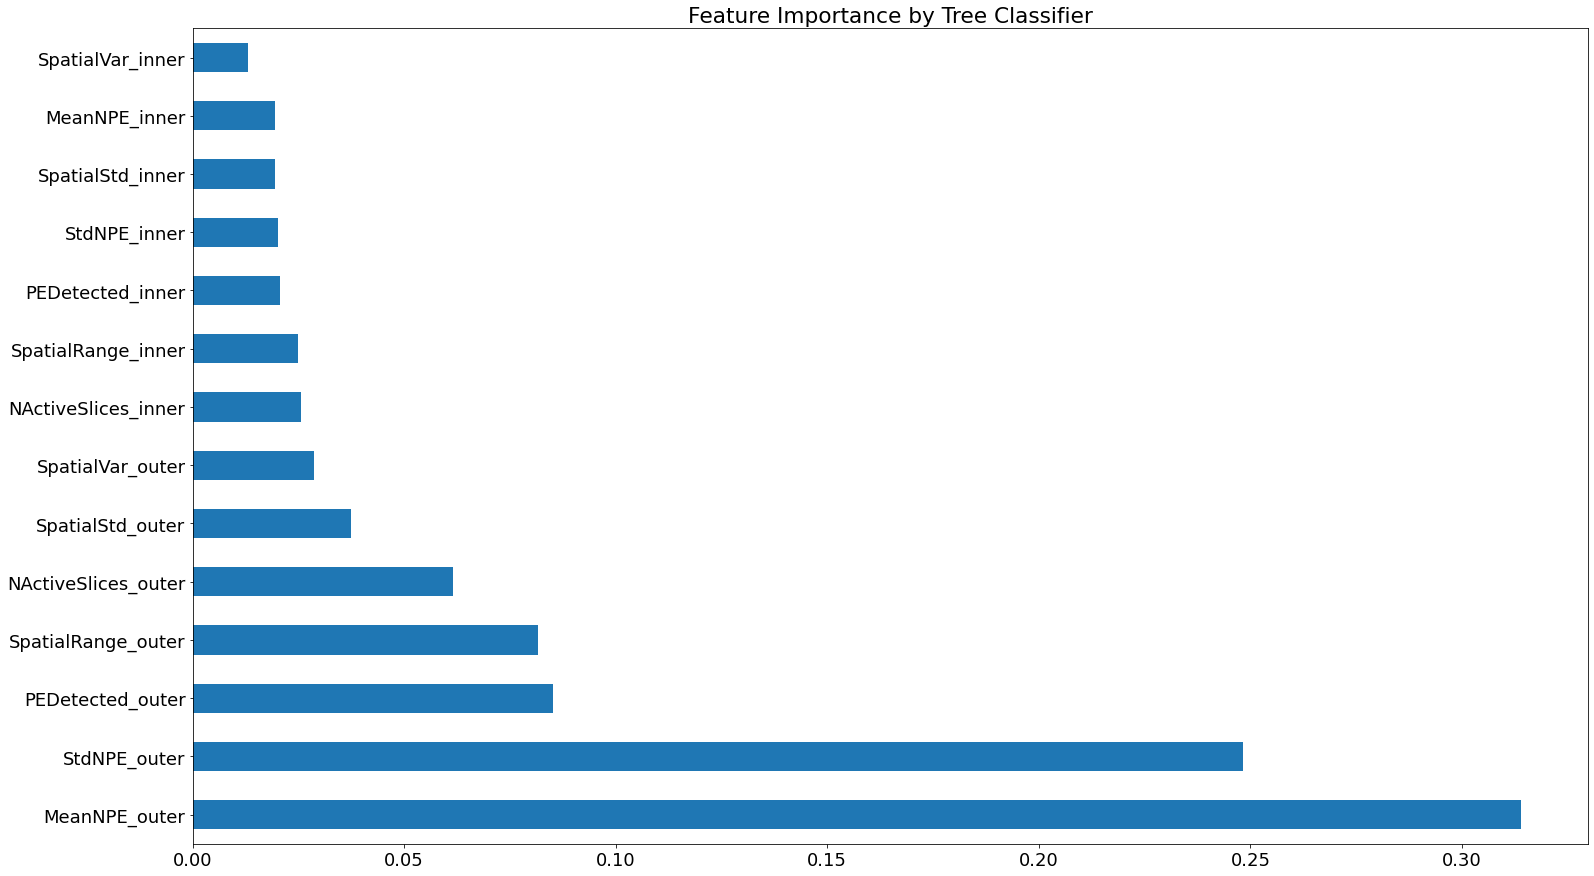

In [19]:
# Feature selection based on Importance of Tree Classifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.columns)).plot(kind='barh')
plt.title("Feature Importance by Tree Classifier")
plt.show()

## Importance ~ Correlation Matrix

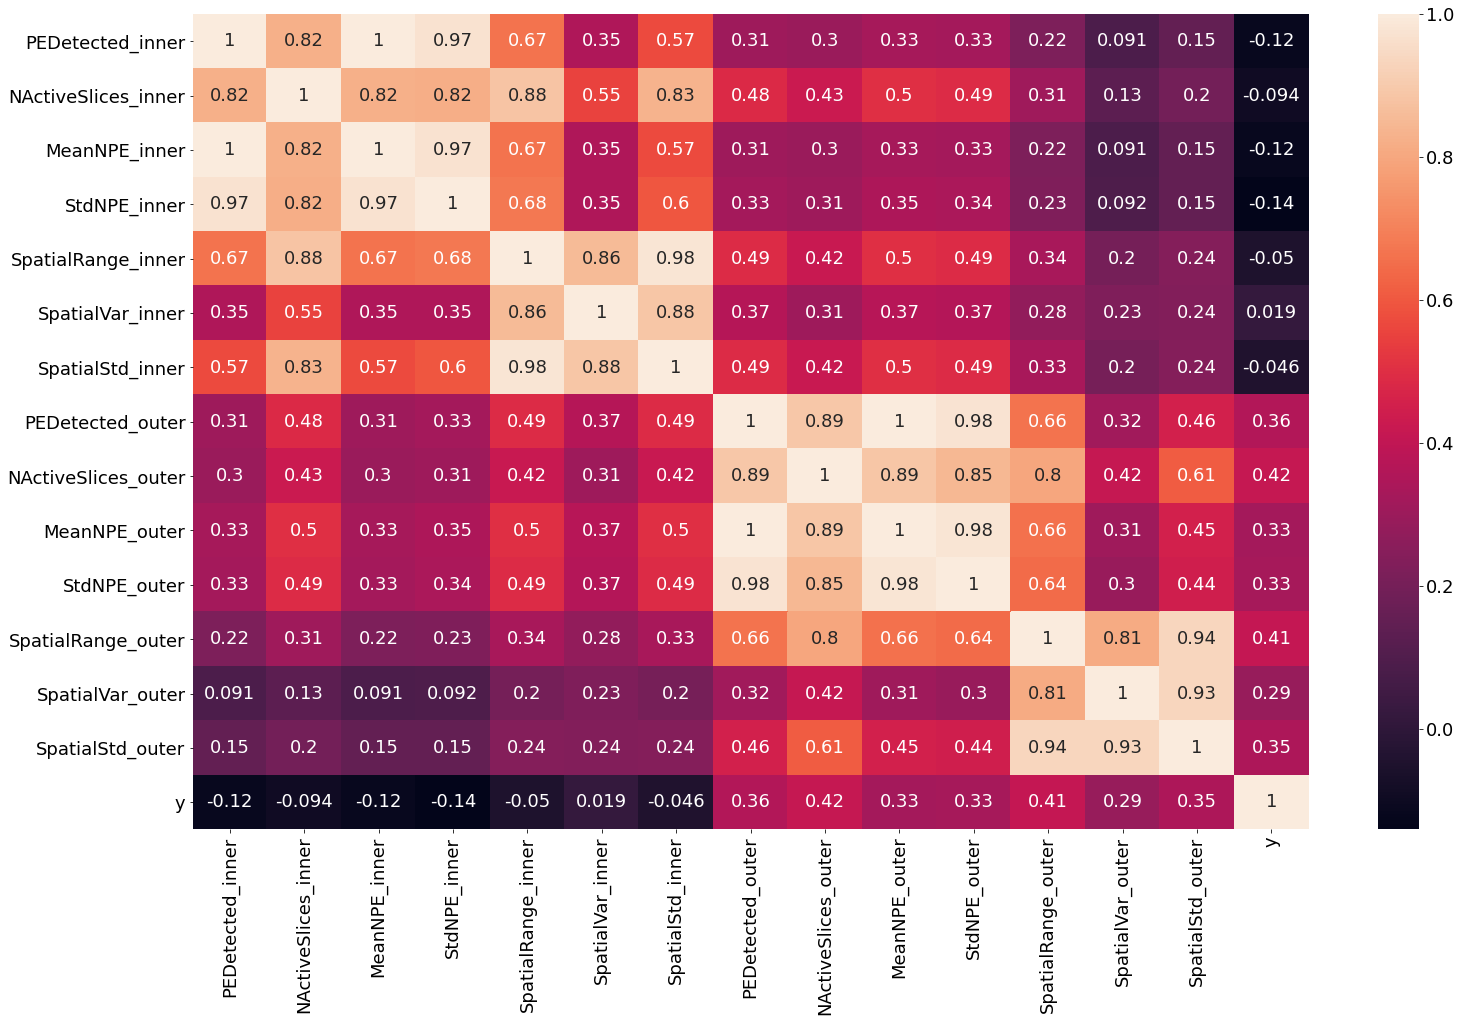

In [20]:
import seaborn as sn

corr_matrix = pd.concat([mu_feat, ar39_feat]).corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [21]:
from itertools import chain
threshold = 0.95

cor = pd.concat([mu_feat.drop(["y"], axis=1), ar39_feat.drop(["y"], axis=1)]).corr()
cor.loc[:,:] =  np.tril(cor, k=-1)
cor = cor.stack()
correlated = cor[abs(cor) > threshold].reset_index() #.loc[:,['level_0','level_1']]
correlated = correlated.query('level_0 not in level_1')
correlated.columns = ["Var0", "Var1", "Corr"]

noncorr_mu_feat = mu_feat.drop(correlated.Var1, axis=1)
noncorr_ar39_feat = ar39_feat.drop(correlated.Var1, axis=1)
print("NON CORRELATED FEATURES")
for feat in noncorr_ar39_feat.columns[:-1]:
    print("{}".format(feat), end=", ")
print()

NON CORRELATED FEATURES
NActiveSlices_inner, StdNPE_inner, SpatialVar_inner, SpatialStd_inner, NActiveSlices_outer, StdNPE_outer, SpatialRange_outer, SpatialVar_outer, SpatialStd_outer, 


## Observation on Feature Selection:
1. Both the F-score and DTree Importance analysis show that feature on Outer Shroud are more meaningful for this classification. This is not surprising since LE Muons mainly involve the outer region.
1. F-score analysis places in the first position the Nr of Active Slices, the Spatial Range and the NPE in the outer region. The DTree classifier places in the first position the energy-related features (mean NPE, std NPE, NPE). 
1. The correlation matrix shows that Inner features are correlated with Ar39. Outer features are correlated with Muons.

We now select the features with correlation <95%

# Train Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

init = time.time()

# Prepare data for training
data = pd.concat([noncorr_mu_feat, noncorr_ar39_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

print("[Info] Tune criterion")
parameters = {'criterion': ['gini', 'entropy']}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(max_depth=8, min_samples_leaf=1), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_criterion = clf.best_params_["criterion"]
print("Best Criterion: {} => Score: {}".format(best_criterion, clf.best_score_))


print("\n[Info] Tune Depth, Min Samples leaf")
parameters = {'max_depth': [2, 4, 6, 8],
             'min_samples_leaf': [500, 600, 700, 800, 900, 1000]}    

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_max_depth = clf.best_params_["max_depth"]
best_minleaf = clf.best_params_["min_samples_leaf"]
print("Best Max Depth: {}, Best Min Samples Leaf: {} => Score: {}".format(best_max_depth, best_minleaf, clf.best_score_))

print("\n[Info] Best Model Evaluation")
# Use Cross Validation To Evaluate Final Model
print("[Model] Criterion: {}, Max Depth: {}, Min Samples Leaf: {}".format(best_criterion,
                                                                         best_max_depth,
                                                                         best_minleaf))
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
#final_clf.fit(X, y)
CV_Result = cross_val_score(final_clf, X, y, cv=5, scoring='precision')
print("[Results]\n\t5-Fold X-Validation: {}".format(CV_Result))
print("\tMean Score: {:.4f}, Std Dev: {:.4f}".format(CV_Result.mean(), CV_Result.std()))

print("[Time] Elapsed time {}".format(time.time() - init))


[Info] Tune criterion
Best Criterion: entropy => Score: 0.9455867155042593

[Info] Tune Depth, Min Samples leaf
Best Max Depth: 2, Best Min Samples Leaf: 700 => Score: 0.8168004507228318

[Info] Best Model Evaluation
[Model] Criterion: entropy, Max Depth: 2, Min Samples Leaf: 700
[Results]
	5-Fold X-Validation: [0.78645833 0.8286445  0.80224719 0.83622829 0.83042394]
	Mean Score: 0.8168, Std Dev: 0.0192
[Time] Elapsed time 0.6213226318359375


Feature: NActiveSlices_inner =>	Score: 0.00000
Feature: StdNPE_inner =>	Score: 0.00000
Feature: SpatialVar_inner =>	Score: 0.00000
Feature: SpatialStd_inner =>	Score: 0.00000
Feature: NActiveSlices_outer =>	Score: 0.30427
Feature: StdNPE_outer =>	Score: 0.00000
Feature: SpatialRange_outer =>	Score: 0.69573
Feature: SpatialVar_outer =>	Score: 0.00000
Feature: SpatialStd_outer =>	Score: 0.00000


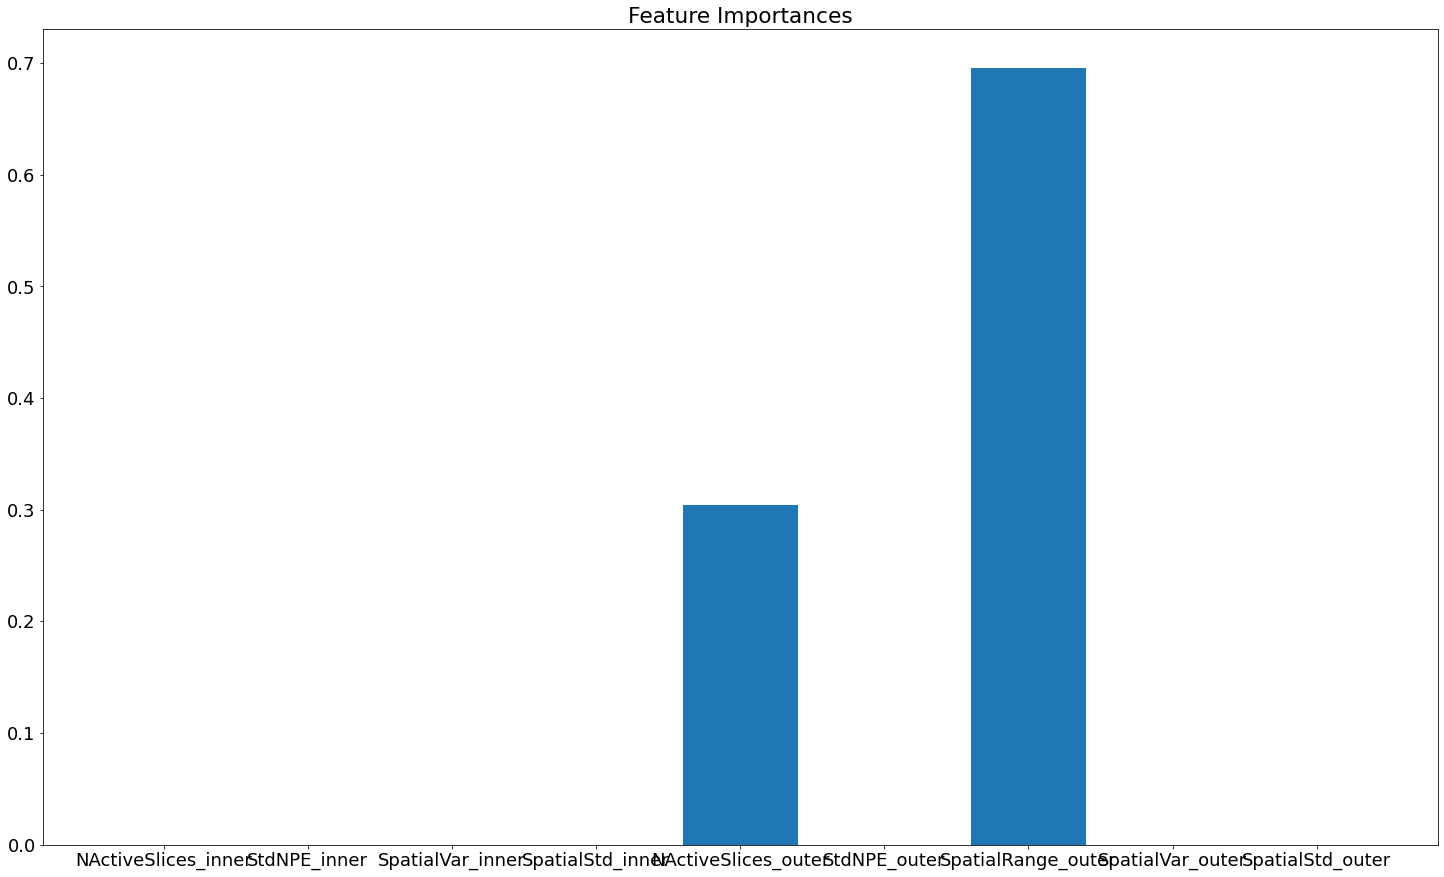

In [47]:
# Train final model
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
final_clf.fit(X, y)

full_feature_names = noncorr_ar39_feat.columns[:-1]
short_feature_names = full_feature_names
# get importance
importances = final_clf.feature_importances_
# summarize feature importance
for i, (name, shortn, v) in enumerate(zip(full_feature_names, short_feature_names, importances)):
	print('Feature: %s =>\tScore: %.5f' % (name, v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.xticks(range(0, len(short_feature_names)), short_feature_names)
plt.title("Feature Importances")
plt.show()

## Evaluate DTree on Test Data

In [29]:
# Prepare data
init = time.time()

mu_feat["PEDetected_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPE_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
mu_feat["StdNPE_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
mu_feat["SpatialRange_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)

init = time.time()
mu_test_feat = pd.DataFrame()
mu_test_feat["PEDetected_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPE_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe(row), axis=1)
mu_test_feat["StdNPE_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe(row), axis=1)
mu_test_feat["SpatialRange_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
mu_test_feat["SpatialVar_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
mu_test_feat["SpatialStd_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_test_feat["PEDetected_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPE_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
mu_test_feat["StdNPE_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
mu_test_feat["SpatialRange_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
mu_test_feat["SpatialVar_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
mu_test_feat["SpatialStd_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar_test_feat = pd.DataFrame()
ar_test_feat["PEDetected_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPE_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe(row), axis=1)
ar_test_feat["StdNPE_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe(row), axis=1)
ar_test_feat["SpatialRange_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
ar_test_feat["SpatialVar_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
ar_test_feat["SpatialStd_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar_test_feat["PEDetected_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPE_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
ar_test_feat["StdNPE_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
ar_test_feat["SpatialRange_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
ar_test_feat["SpatialVar_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
ar_test_feat["SpatialStd_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.094 sec
Compute Mu Inner features: 0.120 sec
Compute Mu features: 270.939 sec
Compute Mu features: 373.344 sec


In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv

# Test model
init = time.time()

mu_test_feat["y"] = 1
ar_test_feat["y"] = 0
noncorr_mu_test_feat = mu_test_feat[noncorr_mu_feat.columns]
noncorr_ar_test_feat = ar_test_feat[noncorr_ar39_feat.columns]
test_data = pd.concat([noncorr_mu_test_feat, noncorr_ar_test_feat], axis=0)
X, y = test_data.iloc[:, :-1], test_data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

y_pred = final_clf.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(598 Mu, 2000000 Ar):
Accuracy: 0.879, Precision: 0.001, Recall: 0.482, F1: 0.002

[Result] Conf. Matrix: TN: 1757442, FP: 242558, FN: 310, TP: 288 | TPR: 48.16%, FPR: 12.13%



## Observations on LE Muons:
We are considering a very "low-energy" scenario <60PE.
We aim to reduce the FPR as much as possible, to have a consequent low trigger rate.

### Old 72Slices Map:
1. Using all the features on the cylinder, we tested the trained model on 500 Muons and 1M Ar39s. It achieves Efficiency=TPR=34.65% and FPR=8.26%.

### Old 12-20Slices Maps:
1. Using non-correlated features on Inner and Outer Shroud, we tested the trained model on 598 Muons and 2M Ar39s. It achieves Efficiency=TPR=38.50% and FPR=3.48%.

### New 12-20Slices Maps, after introducing sampling:
1. Using non-correlated features on Inner and Outer Shroud, we tested the trained model on 598 Muons and 2M Ar39s. It achieves Efficiency=TPR=48.16% and FPR=12.13%. Note: to achieve this result we regularize the parameters to avoid overfitting on training data.

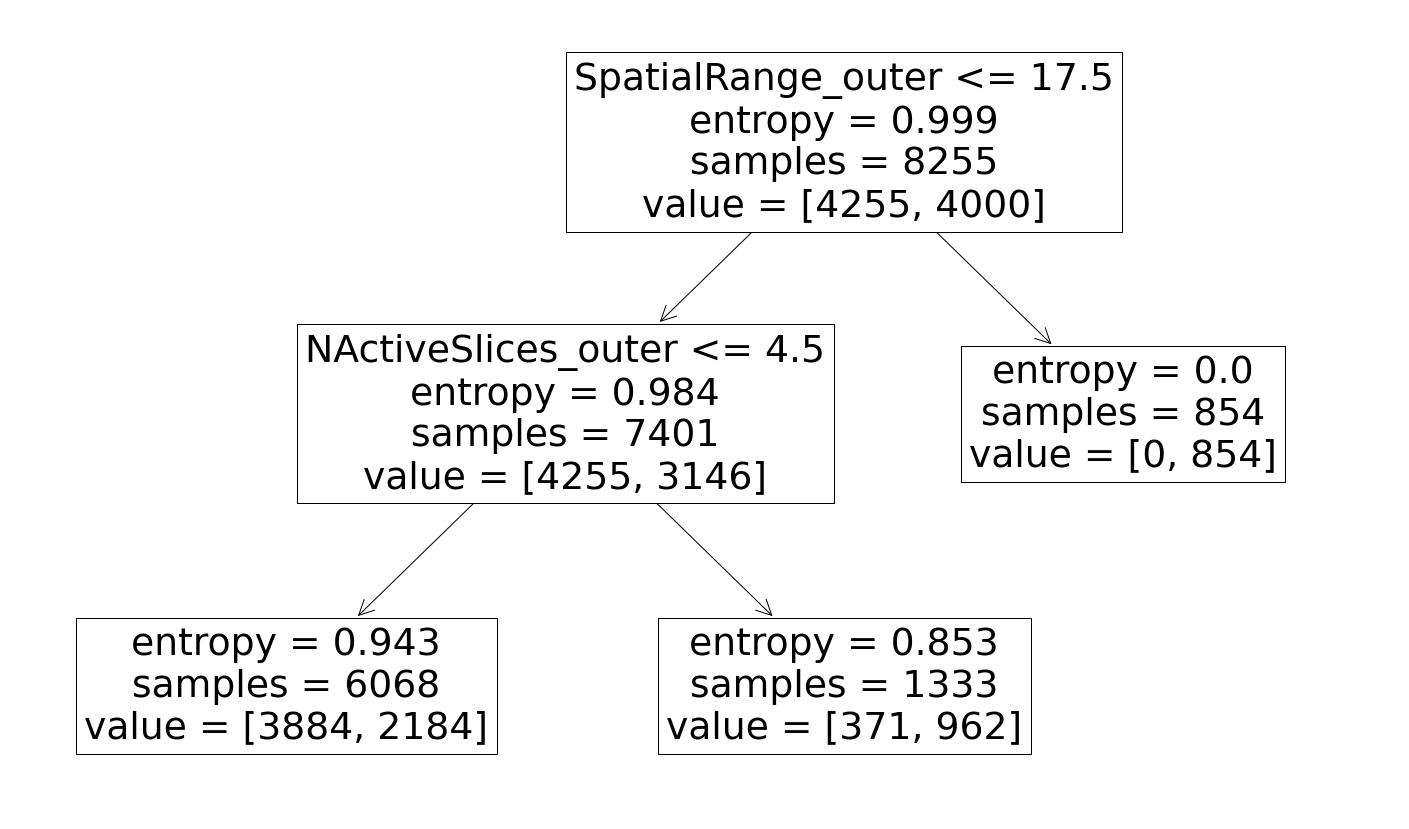

In [49]:
from sklearn import tree

tree.plot_tree(final_clf, feature_names=noncorr_ar39_feat.columns[:-1])
plt.show()

# Look at what kind of muons DTree works

Muons in test set (598 instances):
Detected   (TP):	288 Muons
Undetected (FN):	310 Muons


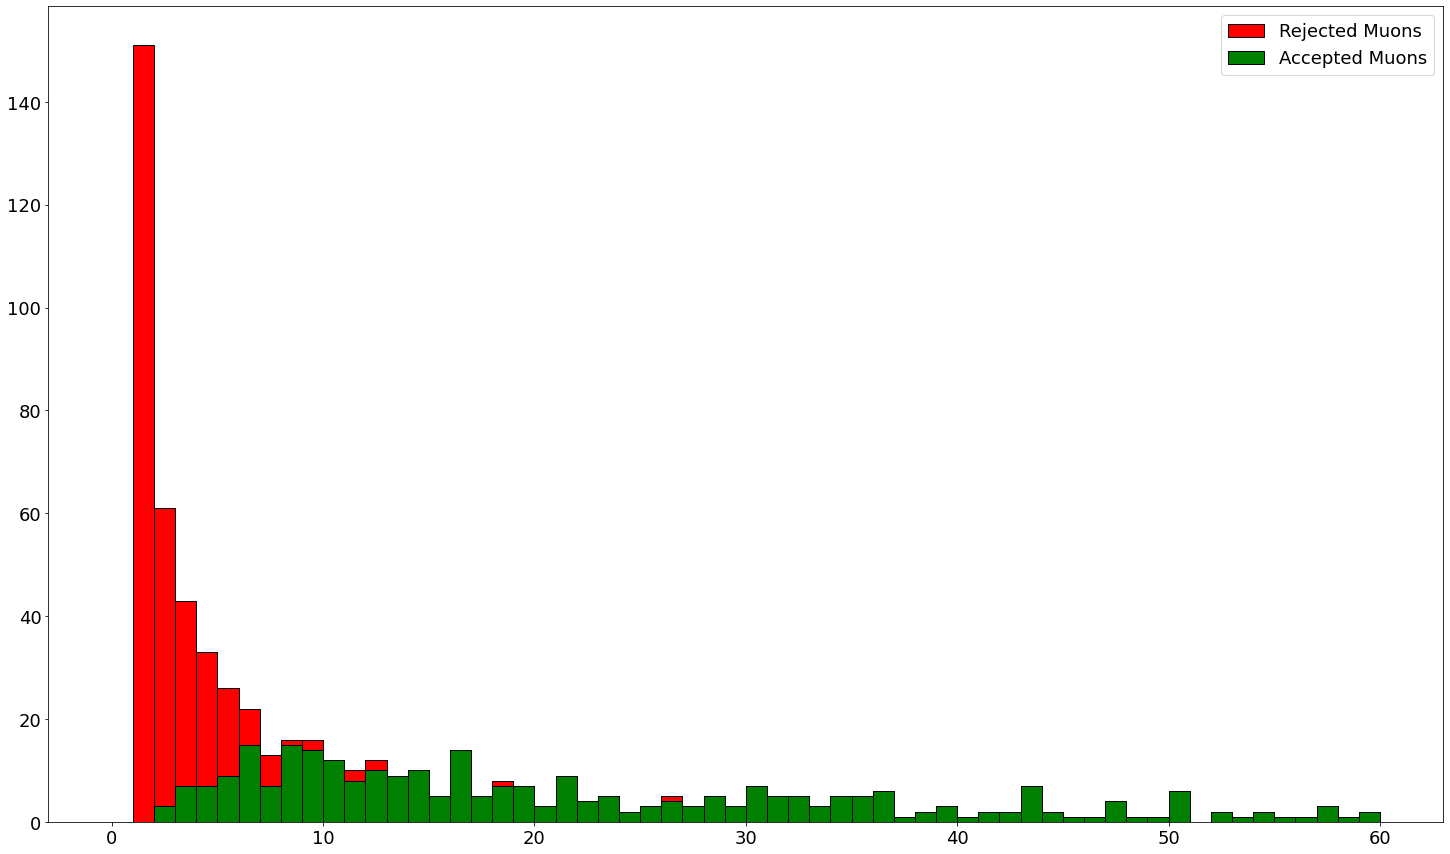

In [52]:
# Muons
mu_fneg = mu_test_feat[((mu_test_feat.SpatialRange_outer<=17.5) & (mu_test_feat.NActiveSlices_outer<=4.5))]
mu_tpos = mu_test_feat[((mu_test_feat.SpatialRange_outer>17.5) | 
                        ((mu_test_feat.SpatialRange_outer<=17.5) & (mu_test_feat.NActiveSlices_outer>4.5)))]

print("Muons in test set ({} instances):".format(len(mu_tpos) + len(mu_fneg)))
print("Detected   (TP):\t{} Muons".format(len(mu_tpos)))
print("Undetected (FN):\t{} Muons".format(len(mu_fneg)))

bins = np.linspace(0, 60, 61)
plt.hist(mu_test_feat.PEDetected_inner+mu_test_feat.PEDetected_outer, bins=bins, label="Rejected Muons", color='r', edgecolor='k')
plt.hist(mu_tpos.PEDetected_inner+mu_tpos.PEDetected_outer, bins=bins, label="Accepted Muons", color='g', edgecolor='k')
plt.legend()
plt.show()

Ar39 in test set (2000000 instances):
Rejected   (TN):	1757442 Ar39
Accepted   (FP):	242558 Ar39


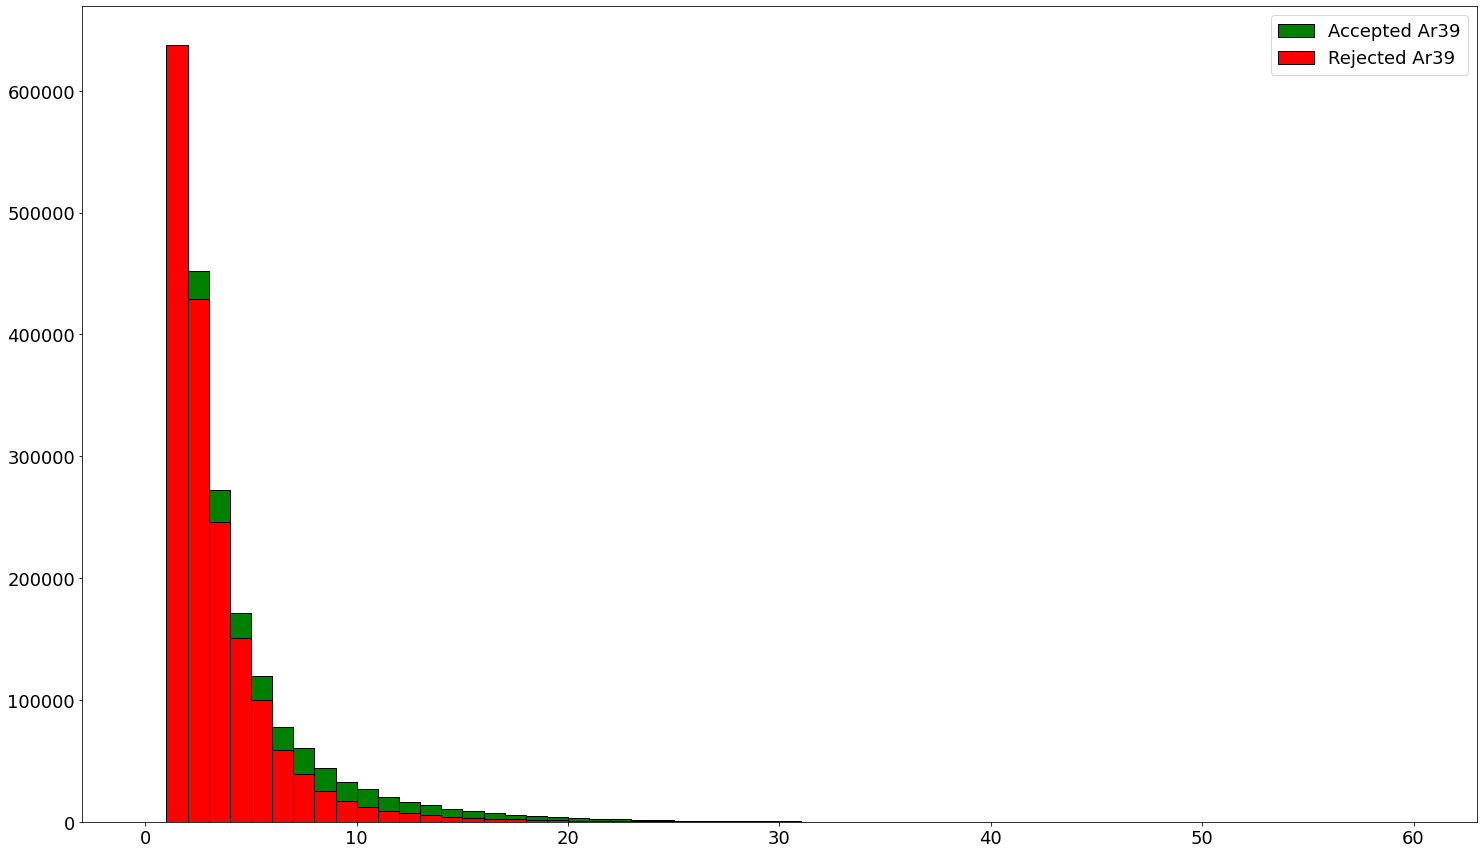

In [53]:
# Ar39
ar_fpos = ar_test_feat[(((ar_test_feat.SpatialRange_outer<=17.5) & (ar_test_feat.NActiveSlices_outer>4.5)) |
                       (ar_test_feat.SpatialRange_outer>17.5))]
ar_tneg = ar_test_feat[(ar_test_feat.SpatialRange_outer<=17.5) & (ar_test_feat.NActiveSlices_outer<=4.5)]

print("Ar39 in test set ({} instances):".format(len(ar_tneg) + len(ar_fpos)))
print("Rejected   (TN):\t{} Ar39".format(len(ar_tneg)))
print("Accepted   (FP):\t{} Ar39".format(len(ar_fpos)))

bins = np.linspace(0, 60, 61)
plt.hist(ar_test_feat.PEDetected_inner+ar_test_feat.PEDetected_outer, bins=bins, label="Accepted Ar39", color='g', edgecolor='k')
plt.hist(ar_tneg.PEDetected_inner+ar_tneg.PEDetected_outer, bins=bins, label="Rejected Ar39", color='r', edgecolor='k')
plt.legend()
plt.show()

# Test on all muons (even >60PE)

In [54]:
init = time.time()
all_mu_feat = pd.DataFrame()
all_mu_feat["PEDetected_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
all_mu_feat["NActiveSlices_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_mu_feat["MeanNPE_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe(row), axis=1)
all_mu_feat["StdNPE_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe(row), axis=1)
all_mu_feat["SpatialRange_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
all_mu_feat["SpatialVar_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
all_mu_feat["SpatialStd_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
all_mu_feat["PEDetected_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
all_mu_feat["NActiveSlices_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_mu_feat["MeanNPE_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe(row), axis=1)
all_mu_feat["StdNPE_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe(row), axis=1)
all_mu_feat["SpatialRange_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
all_mu_feat["SpatialVar_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
all_mu_feat["SpatialStd_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 2.714 sec
Compute Mu Inner features: 3.283 sec


# Observations:
1. This trigger is **effective** even for **muons wt >60PE detected**!!!
1. The resulting tree has depth 2!

Muons in test set (14737 instances):
Detected   (TP):	12243 Muons
Undetected (FN):	2494 Muons
Efficiency (TPR):	83.077%


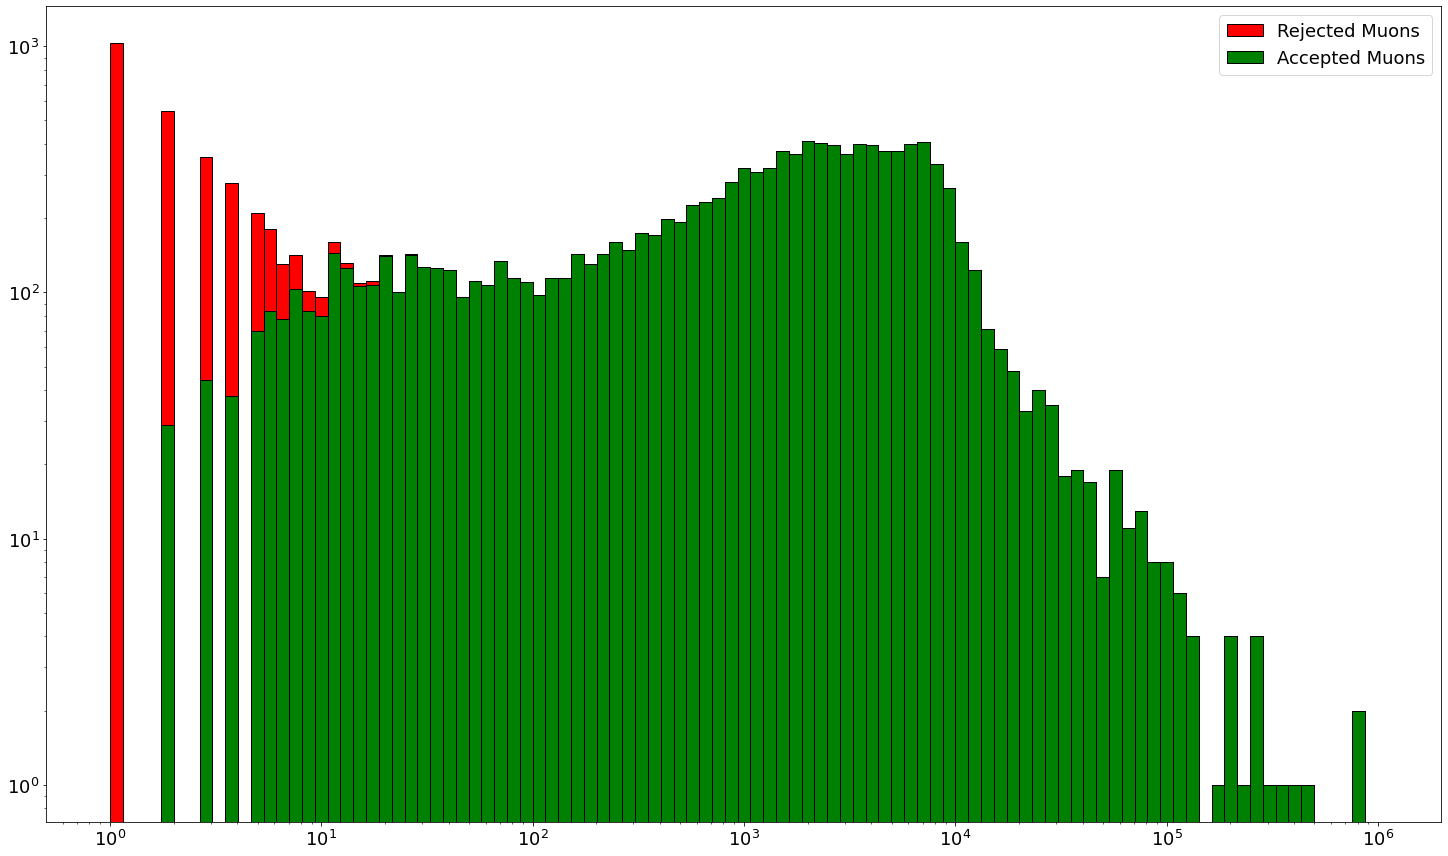

In [64]:
# Muons
allmu_fneg = all_mu_feat[((all_mu_feat.SpatialRange_outer<=17.5) & (all_mu_feat.NActiveSlices_outer<=4.5))]
allmu_tpos = all_mu_feat[((all_mu_feat.SpatialRange_outer>17.5) |
                       ((all_mu_feat.SpatialRange_outer<=17.5) & (all_mu_feat.NActiveSlices_outer>4.5)))]

print("Muons in test set ({} instances):".format(len(allmu_tpos) + len(allmu_fneg)))
print("Detected   (TP):\t{} Muons".format(len(allmu_tpos)))
print("Undetected (FN):\t{} Muons".format(len(allmu_fneg)))
print("Efficiency (TPR):\t{:.3f}%".format(len(allmu_tpos) / len(all_mu_feat) * 100))

bins = np.logspace(0, 6, 100)
plt.hist(all_mu_feat.PEDetected_inner+all_mu_feat.PEDetected_outer, bins=bins, label="Rejected Muons", color='r', edgecolor='k')
plt.hist(allmu_tpos.PEDetected_inner+allmu_tpos.PEDetected_outer, bins=bins, label="Accepted Muons", color='g', edgecolor='k')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

## Results of this approach
Evaluation on 14K muons and 2M Ar39s:
1. Accuracy: (12243+1757442)/(14737+2000000) = 0.8783
1. Efficiency: 12243/14737 = 0.8307
1. Purity: 12243/(12243+242558) = 0.0453

# Try to simplify the features
Motivation: std dev, var are computationally expensive, PEDetected is a sum, Range is a difference. They could fit better the real-time setting.

In [92]:
from itertools import chain
threshold = 0.95

cor = pd.concat([mu_feat.drop(["y"], axis=1), ar39_feat.drop(["y"], axis=1)]).corr()
cor.loc[:,:] =  np.tril(cor, k=-1)
cor = cor.stack()
correlated = cor[abs(cor) > threshold].reset_index() #.loc[:,['level_0','level_1']]
correlated = correlated.query('level_0 not in level_1')
correlated.columns = ["Var0", "Var1", "Corr"]
print(correlated)

my_features = ["PEDetected_inner", "NActiveSlices_inner", "SpatialRange_inner",
               "PEDetected_outer", "NActiveSlices_outer", "SpatialRange_outer"]

print("\nBased on this data, and the correlation matrix. I propose the following features:")
for feat in my_features:
    print("{}".format(feat), end=", ")
print()

mu_myfeat = mu_feat.loc[:, my_features]
ar39_myfeat = ar39_feat.loc[:, my_features]

               Var0                Var1      Corr
1      StdNPE_inner    PEDetected_inner  0.972180
2      StdNPE_inner       MeanNPE_inner  0.972180
3  SpatialStd_inner  SpatialRange_inner  0.981535
5      StdNPE_outer    PEDetected_outer  0.975279
6      StdNPE_outer       MeanNPE_outer  0.978569

Based on this data, and the correlation matrix. I propose the following features:
PEDetected_inner, NActiveSlices_inner, SpatialRange_inner, PEDetected_outer, NActiveSlices_outer, SpatialRange_outer, 


## Train DTree on these features

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

init = time.time()

# Prepare data for training
mu_myfeat["y"] = 1
ar39_myfeat["y"] = 0
data = pd.concat([mu_myfeat, ar39_myfeat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

print("[Info] Tune criterion")
parameters = {'criterion': ['gini', 'entropy']}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(max_depth=4, min_samples_leaf=1), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_criterion = clf.best_params_["criterion"]
print("Best Criterion: {} => Score: {}".format(best_criterion, clf.best_score_))


print("\n[Info] Tune Depth, Min Samples leaf")
parameters = {'min_samples_leaf': [500, 700, 600, 800, 900, 1000]}    

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion, max_depth=4), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
best_minleaf = clf.best_params_["min_samples_leaf"]
print("Best Min Samples Leaf: {} => Score: {}".format(best_minleaf, clf.best_score_))

parameters = {'max_depth': [2, 3, 4, 6, 8]}
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_minleaf), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
best_max_depth = clf.best_params_["max_depth"]
print("Best Max Depth: {} => Score: {}".format(best_max_depth, clf.best_score_))

print("\n[Info] Best Model Evaluation")
# Use Cross Validation To Evaluate Final Model
print("[Model] Criterion: {}, Max Depth: {}, Min Samples Leaf: {}".format(best_criterion,
                                                                         best_max_depth,
                                                                         best_minleaf))
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
#final_clf.fit(X, y)
CV_Result = cross_val_score(final_clf, X, y, cv=5, scoring='precision')
print("[Results]\n\t5-Fold X-Validation: {}".format(CV_Result))
print("\tMean Score: {:.4f}, Std Dev: {:.4f}".format(CV_Result.mean(), CV_Result.std()))

print("[Time] Elapsed time {}".format(time.time() - init))

[Info] Tune criterion
Best Criterion: entropy => Score: 0.8845505909514266

[Info] Tune Depth, Min Samples leaf
Best Min Samples Leaf: 500 => Score: 0.7532829129007439
Best Max Depth: 2 => Score: 0.801140245816029

[Info] Best Model Evaluation
[Model] Criterion: entropy, Max Depth: 2, Min Samples Leaf: 500
[Results]
	5-Fold X-Validation: [0.78645833 0.83140878 0.78277154 0.81147541 0.79358717]
	Mean Score: 0.8011, Std Dev: 0.0181
[Time] Elapsed time 0.30359578132629395


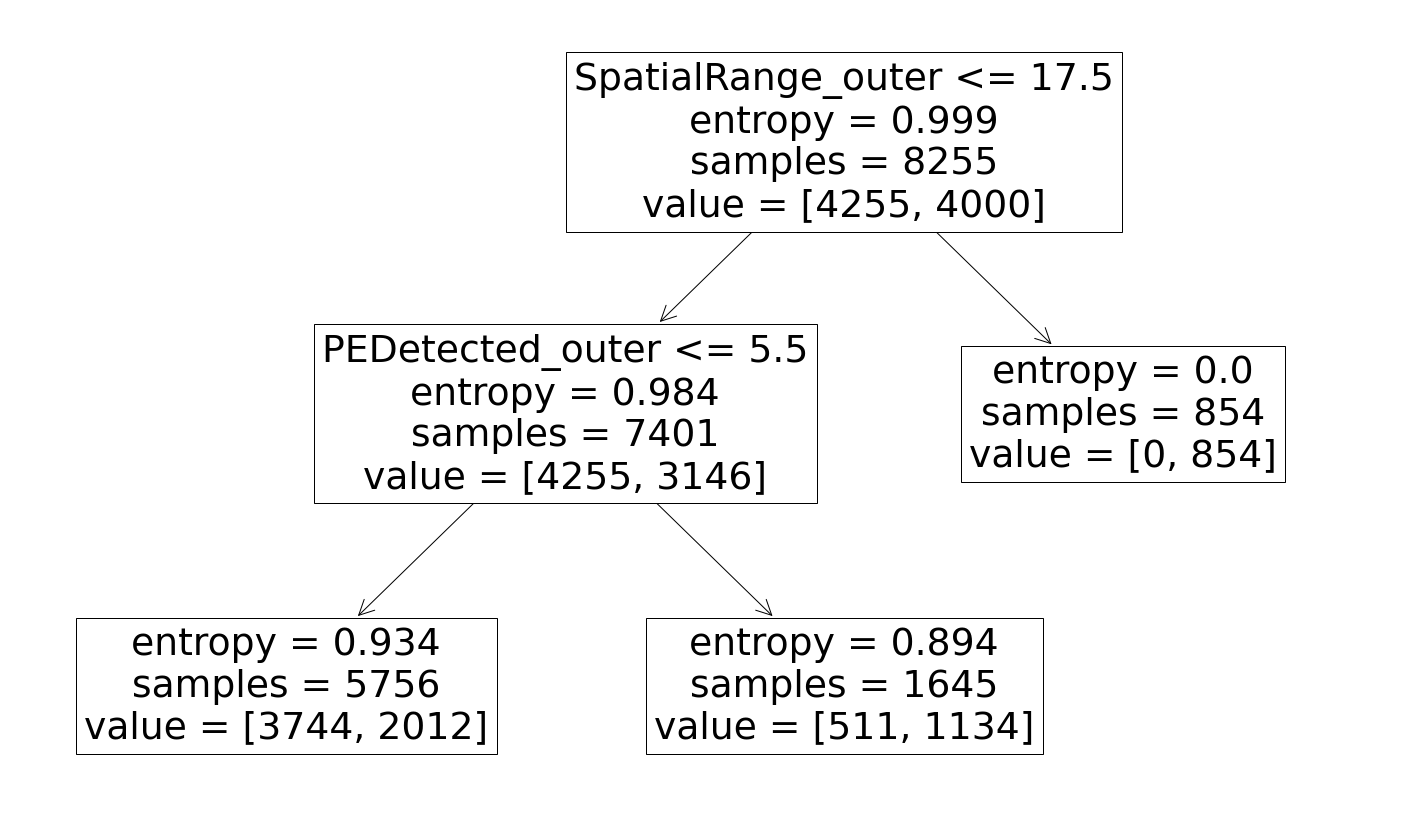

In [107]:
final_clf.fit(X, y)
tree.plot_tree(final_clf, feature_names=ar39_myfeat.columns[:-1])
plt.show()

Feature: PEDetected_inner =>	Score: 0.00000
Feature: NActiveSlices_inner =>	Score: 0.00000
Feature: SpatialRange_inner =>	Score: 0.00000
Feature: PEDetected_outer =>	Score: 0.31041
Feature: NActiveSlices_outer =>	Score: 0.00000
Feature: SpatialRange_outer =>	Score: 0.68959


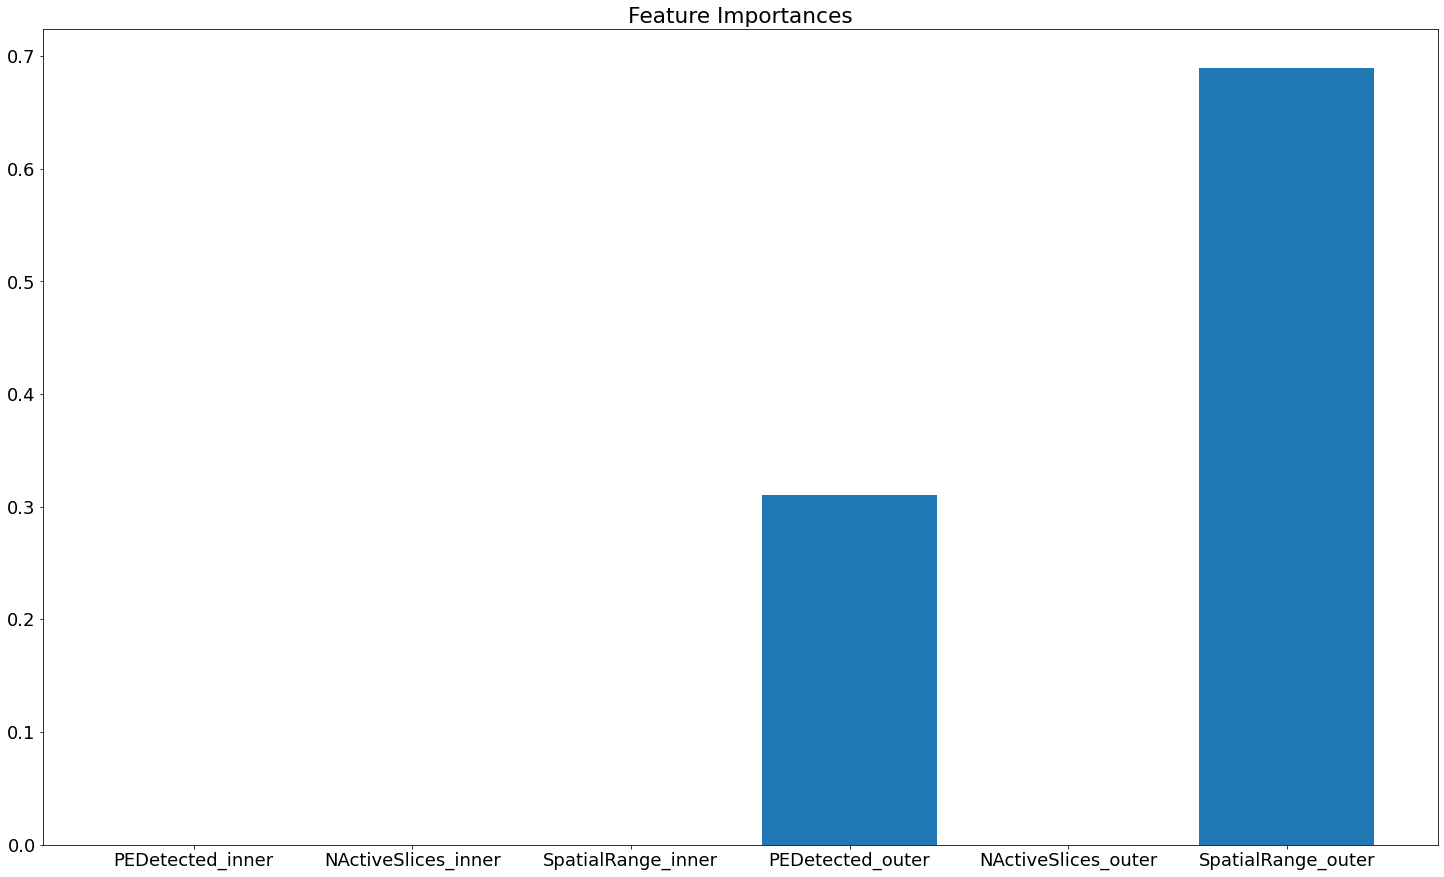

In [108]:
# Train final model
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
final_clf.fit(X, y)

full_feature_names = ar39_myfeat.columns[:-1]
short_feature_names = full_feature_names
# get importance
importances = final_clf.feature_importances_
# summarize feature importance
for i, (name, shortn, v) in enumerate(zip(full_feature_names, short_feature_names, importances)):
	print('Feature: %s =>\tScore: %.5f' % (name, v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.xticks(range(0, len(short_feature_names)), short_feature_names)
plt.title("Feature Importances")
plt.show()

In [109]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv

# Test model
init = time.time()

mu_test_my_feat = mu_test_feat.loc[:, my_features]
ar_test_my_feat = ar_test_feat.loc[:, my_features]
mu_test_my_feat["y"] = 1
ar_test_my_feat["y"] = 0
test_data = pd.concat([mu_test_my_feat, ar_test_my_feat], axis=0)
X, y = test_data.iloc[:, :-1], test_data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

y_pred = final_clf.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(598 Mu, 2000000 Ar):
Accuracy: 0.857, Precision: 0.001, Recall: 0.510, F1: 0.002

[Result] Conf. Matrix: TN: 1714391, FP: 285609, FN: 293, TP: 305 | TPR: 51.00%, FPR: 14.28%



In [ ]:
# Observations:
1. This approach cannot reduce the FPR, try to unbalance the training data, increasing the number of instances for high-NPE Ar39
1. In this way, the purity would be more in